<h2><center>ECE 594N: Homework 4 Group Project</center></h2>
<h1><center>Human Pose Classifcation Using Manifold Learning</center></h1>
<h3><center>by Abhijith Atreya, Jax Burd, and Christos Zangos</center></h3>
    
---------------------------------------------------------------------------------------------------------------------------

# Project Goal

To distinguish between certain actions using 2D full body-based keypoints pulled from an open dataset. We first performed 2 PCA methods to extract a minimum number of components to represent our data. Both of which we apply logistic regression and compare classifcation accuracies for various number of components chosen.

![](images/human_poses.JPG)


# MPII Human Pose Dataset
- <b>Dataset available at:</b> <http://human-pose.mpi-inf.mpg.de/>


- <b>Citation:</b> <em>Mykhaylo Andriluka and Leonid Pishchulin and Peter Gehler and Schiele, Bernt. 2D Human Pose Estimation: New Benchmark and State of the Art Analysis. IEEE Conference on Computer Vision and Pattern Recognition (CVPR). Jun 2014</em>

Created as a new benchmark for 2D human pose estimation in 2014, MPII Human pose features about 25K images total, and over 40K people with annotated body joints. The images and their annotations depict 410 different human activities. Some examples are (but not limited to) dancing, running, playing a musical intrument, meditating, etc.

![](images/human_pose_activities.PNG)

All images were extracted from YouTube, and was the result of a collaboration from researches at the Max Planck Institute for Intelligent Systems in Germany and Stanford University in the United States.

### Keypoint Labels
The dataset annotated all the joints on their images with the 16 total features listed below, each containing a x and y position coordinate. The dataset also tells us whether or not the joint is visible, as some images don't show the who human body or people are angled in such a way that a keypoint is hidden.

![](images/skeleton_diagram.PNG)



### Running and Cycling
In our project we wanted to focus on two activities within the dataset that would be reasonable to distinguish based off their keypoint skeletons. For this reason we decided to attempt classifying between the activities of <b>running</b> and <b>cycling</b>, as it was assumed their poses are distinct enough to yeild good results.


![](images/keypoints.JPG)


# Implementation


In [1]:
import matplotlib.pyplot as plt
import cv2
import scipy.io as sio
import pandas as pd
import numpy as np
from utils import *
from sklearn.model_selection import train_test_split
from geomstats.geometry.euclidean import EuclideanMetric

INFO: Using numpy backend


In [2]:
# Load the MPII dataset
mat = sio.loadmat('mpii_human_pose_v1_u12_2/mpii_human_pose_v1_u12_1.mat', struct_as_record=False)

In [3]:

rel = mat['RELEASE']

obj_rel = rel[0,0]

annolist = obj_rel.__dict__['annolist']
img_tra = obj_rel.__dict__['img_train']
act = obj_rel.__dict__['act']

n = annolist.shape[1]

In [4]:
# All the columns of the data 

data_arr = ['NAME','r ankle_X','r ankle_Y', 'r knee_X','r knee_Y', 'r hip_X','r hip_Y', 'l hip_X','l hip_Y', 'l knee_X','l knee_Y', 'l ankle_X','l ankle_Y','pelvis_X','pelvis_Y','thorax_X','thorax_Y','upper neck_X','upper neck_Y', 'head top_X','head top_Y', 'r wrist_X','r wrist_Y','r elbow_X','r elbow_Y', 'r shoulder_X','r shoulder_Y','l shoulder_X','l shoulder_Y','l elbow_X','l elbow_Y', 'l wrist_X','l wrist_Y','Scale','Activity','Category']

data = pd.DataFrame(columns=data_arr)

Convert_data_to_CSV(annolist, act, data_arr, img_tra)

In [5]:
# Load the CSV
df_obj = pd.read_csv('mpii_dataset.csv')
input_running_filtered, input_cycling_filtered = Clean_data(df_obj,data_arr)

032694102.jpg
(1280, 720)


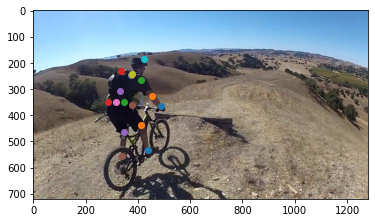

In [6]:
# Display an image with keypoints
# "image_id" is used to index an image from the dataframe
image_id = 15
imag(input_cycling_filtered,input_cycling_filtered.index[image_id])

In [7]:
# Generate dataset and labels 

running, r_labels=format_dataframe(input_running_filtered,0)
cycling, c_labels=format_dataframe(input_cycling_filtered,1)

dataset=np.concatenate((running,cycling))
labels=np.concatenate((r_labels,c_labels))
dataset[np.isnan(dataset).any(axis=2)] = 0

# Principle Component Analysis


## On Euclidean Space


Average Training accuracy: 0.81674
Average Test accuracy: 0.75153


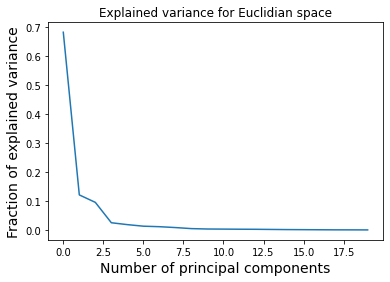

In [9]:
# PCA
train_acc_avg = list()
test_acc_avg = list()
ncomponenets = 20
for i in range(10):
    train_acc, test_acc , pca = Euclidian_LR(dataset,labels, ncomponenets)
    train_acc_avg.append(train_acc)
    test_acc_avg.append(test_acc)

plt.figure()
plt.plot(pca.explained_variance_ratio_)
plt.xlabel("Number of principal components", size=14)
plt.ylabel("Fraction of explained variance", size=14);
plt.title("Explained variance for Euclidian space")


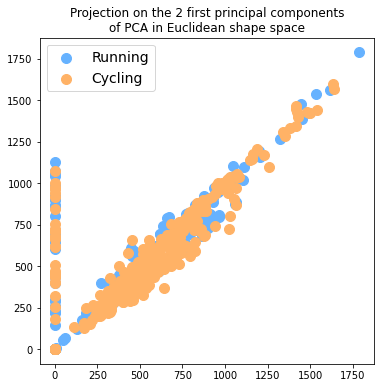

In [10]:
# Projection of First X Pricinple Components

label_to_str = {0: "Running", 1: "Cycling"}
label_to_color = {
    0: (102 / 255, 178 / 255, 255 / 255, 1.0),
    1: (255 / 255, 178 / 255, 102 / 255, 1.0),
}

plt.figure(figsize=(6, 6))
for label, col in label_to_color.items():
    mask = labels == label
    plt.scatter(dataset[mask, 0], dataset[mask, 1], color=col, s=100, label=label_to_str[label])
plt.legend(fontsize=14)
plt.title(
    "Projection on the 2 first principal components"
    "\nof PCA in Euclidean shape space"
);

## On Kendall Shape Space

Average Training accuracy: 0.7479000000000001
Average Test accuracy: 0.6788000000000001


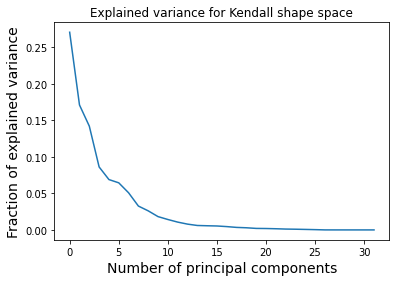

In [12]:
# Tangent PCA
# Perform classification on tangent space

train_acc_avg = list()
test_acc_avg = list()
n_components = 32
for i in range(10):
    t_pca, X , train_acc, test_acc ,sizes = Geometric_LR(dataset,labels, n_components)
    train_acc_avg.append(train_acc)
    test_acc_avg.append(test_acc)

plt.figure()
plt.plot(t_pca.explained_variance_ratio_)
plt.xlabel("Number of principal components", size=14)
plt.ylabel("Fraction of explained variance", size=14);
plt.title("Explained variance for Kendall shape space")



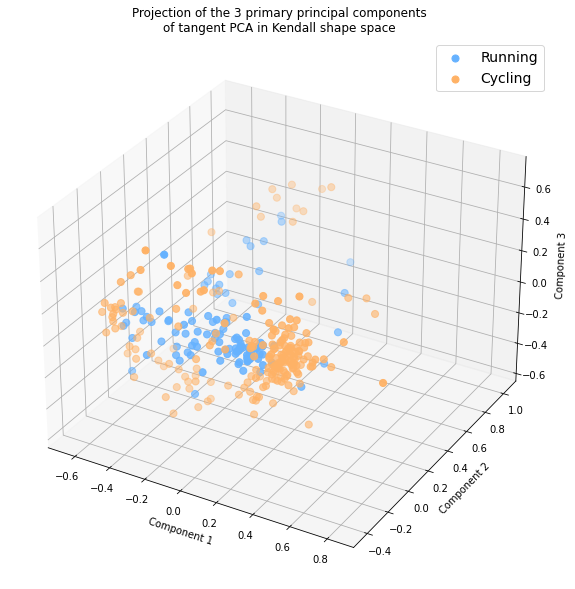

In [29]:
# Projection of First X Pricinple Tangent Components

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection="3d")

for label, col in label_to_color.items():
    mask = labels == label
    ax.scatter(X[mask, 0], X[mask, 1],X[mask, 2], color=col, s=50, label=label_to_str[label])
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.set_zlabel("Component 3")
plt.legend(fontsize=14)
plt.title(
    "Projection of the 3 primary principal components"
    "\nof tangent PCA in Kendall shape space"
);

#assert feature_names[3][:-1]==feature_names[4][:-1]

Text(0.5, 1.0, 'Distance matrix for Kendall shape space')

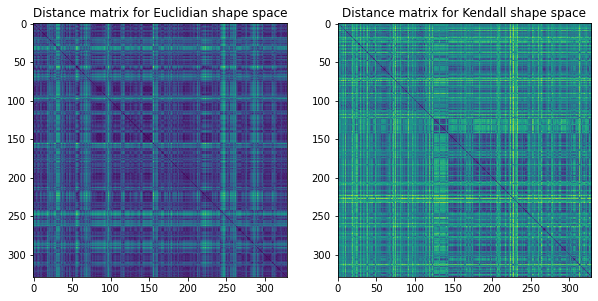

In [14]:
#Distance matrix 

m_ambient = 2
k_landmarks = 16

preshape = PreShapeSpace(m_ambient=m_ambient, k_landmarks=k_landmarks)
matrices_metric = preshape.embedding_metric
pose_preshape = preshape.projection(dataset)
base_point = pose_preshape[0]
pose_shape = preshape.align(point=pose_preshape, base_point=base_point)
kendall_metric = KendallShapeMetric(m_ambient=m_ambient, k_landmarks=k_landmarks)
dist_pairwise = kendall_metric.dist_pairwise(pose_shape)
fig = plt.figure(figsize=(10, 6))

ax = fig.add_subplot(121)

eucl_metric = EuclideanMetric(2 * 16)
nsamples, nx, ny = dataset.shape
posture = dataset.reshape((nsamples,nx*ny))
eucl_pair_dist = eucl_metric.dist_pairwise(posture)
ax.imshow(eucl_pair_dist);
plt.title("Distance matrix for Euclidian shape space")


ax = fig.add_subplot(122)
ax.imshow(dist_pairwise);
plt.title("Distance matrix for Kendall shape space")


In [25]:
# Verify that all points lie on the preshape space
posture_preshape = preshape.projection(dataset)
validate = (preshape.belongs(posture_preshape))
print("Check if points lie on the Kendall shape space : " + str(np.all(validate)))

(329, 16, 2)
Check if points lie on the preshape space : True


## Cross Validation
### Classify the features using Logistic regression

In [15]:
# 2 Principle Components
# PCA

train_acc_avg = list()
test_acc_avg = list()
ncomponenets = 2
for i in range(10):
    train_acc, test_acc , pca = Euclidian_LR(dataset,labels, ncomponenets)
    train_acc_avg.append(train_acc)
    test_acc_avg.append(test_acc)
print("Average Training accuracy (Eucidian metric): " + str(np.mean(train_acc_avg)))
print("Average Test accuracy (Eucidian metric): " + str(np.mean(test_acc_avg)))

# Train PCA
train_acc_avg = list()
test_acc_avg = list()
n_components = 2
for i in range(10):
    t_pca, X , train_acc, test_acc ,sizes = Geometric_LR(dataset,labels, n_components)
    train_acc_avg.append(train_acc)
    test_acc_avg.append(test_acc)

print("Average Training accuracy (Kendall shape metric): " + str(np.mean(train_acc_avg)))
print("Average Test accuracy (Kendall shape metric): " + str(np.mean(test_acc_avg)))

Average Training accuracy (Eucidian metric): 0.6711
Average Test accuracy (Eucidian metric): 0.6984999999999999
Average Training accuracy: 0.6323399999999999
Average Test accuracy: 0.5954699999999999


In [16]:
# 5 Principle Components

train_acc_avg = list()
test_acc_avg = list()
ncomponenets = 5
for i in range(10):
    train_acc, test_acc , pca = Euclidian_LR(dataset,labels, ncomponenets)
    train_acc_avg.append(train_acc)
    test_acc_avg.append(test_acc)
print("Average Training accuracy (Eucidian metric): " + str(np.mean(train_acc_avg)))
print("Average Test accuracy (Eucidian metric): " + str(np.mean(test_acc_avg)))

# Tangent PCA
train_acc_avg = list()
test_acc_avg = list()
for i in range(10):
    t_pca, X , train_acc, test_acc ,sizes = Geometric_LR(dataset,labels, ncomponenets)
    train_acc_avg.append(train_acc)
    test_acc_avg.append(test_acc)

print("Average Training accuracy (Kendall shape metric): " + str(np.mean(train_acc_avg)))
print("Average Test accuracy (Kendall shape metric): " + str(np.mean(test_acc_avg)))

Average Training accuracy (Eucidian metric): 0.69352
Average Test accuracy (Eucidian metric): 0.65152
Average Training accuracy: 0.6874399999999999
Average Test accuracy: 0.6893900000000001


In [17]:
# 10 Principle Components

train_acc_avg = list()
test_acc_avg = list()
ncomponenets = 10
for i in range(10):
    train_acc, test_acc , pca = Euclidian_LR(dataset,labels, ncomponenets)
    train_acc_avg.append(train_acc)
    test_acc_avg.append(test_acc)
print("Average Training accuracy (Eucidian metric): " + str(np.mean(train_acc_avg)))
print("Average Test accuracy (Eucidian metric): " + str(np.mean(test_acc_avg)))

#Tanget PCA
train_acc_avg = list()
test_acc_avg = list()
for i in range(10):
    t_pca, X , train_acc, test_acc ,sizes = Geometric_LR(dataset,labels, ncomponenets)
    train_acc_avg.append(train_acc)
    test_acc_avg.append(test_acc)

print("Average Training accuracy (Kendall shape metric): " + str(np.mean(train_acc_avg)))
print("Average Test accuracy (Kendall shape metric): " + str(np.mean(test_acc_avg)))

Average Training accuracy (Eucidian metric): 0.7734
Average Test accuracy (Eucidian metric): 0.7530399999999999
Average Training accuracy: 0.73076
Average Test accuracy: 0.73334


In [18]:
# 20 Principle Components

train_acc_avg = list()
test_acc_avg = list()
ncomponenets = 20
for i in range(10):
    train_acc, test_acc , pca = Euclidian_LR(dataset,labels, ncomponenets)
    train_acc_avg.append(train_acc)
    test_acc_avg.append(test_acc)
print("Average Training accuracy (Eucidian metric): " + str(np.mean(train_acc_avg)))
print("Average Test accuracy (Eucidian metric): " + str(np.mean(test_acc_avg)))

#Tangent PCA
train_acc_avg = list()
test_acc_avg = list()
for i in range(10):
    t_pca, X , train_acc, test_acc ,sizes = Geometric_LR(dataset,labels, ncomponenets)
    train_acc_avg.append(train_acc)
    test_acc_avg.append(test_acc)

print("Average Training accuracy (Kendall shape metric): " + str(np.mean(train_acc_avg)))
print("Average Test accuracy (Kendall shape metric): " + str(np.mean(test_acc_avg)))

Average Training accuracy (Eucidian metric): 0.8258599999999999
Average Test accuracy (Eucidian metric): 0.77424
Average Training accuracy: 0.74638
Average Test accuracy: 0.73333


In [19]:
# 32 Components (All)

train_acc_avg = list()
test_acc_avg = list()
ncomponenets = 32
for i in range(10):
    train_acc, test_acc , pca = Euclidian_LR(dataset,labels, ncomponenets)
    train_acc_avg.append(train_acc)
    test_acc_avg.append(test_acc)
print("Average Training accuracy (Eucidian metric): " + str(np.mean(train_acc_avg)))
print("Average Test accuracy (Eucidian metric): " + str(np.mean(test_acc_avg)))

# Tangent PCA
train_acc_avg = list()
test_acc_avg = list()
for i in range(10):
    t_pca, X , train_acc, test_acc ,sizes = Geometric_LR(dataset,labels, ncomponenets)
    train_acc_avg.append(train_acc)
    test_acc_avg.append(test_acc)

print("Average Training accuracy (Kendall shape metric): " + str(np.mean(train_acc_avg)))
print("Average Test accuracy (Kendall shape metric): " + str(np.mean(test_acc_avg)))

Average Training accuracy (Eucidian metric): 0.88286
Average Test accuracy (Eucidian metric): 0.79091
Average Training accuracy: 0.7467599999999999
Average Test accuracy: 0.71667


# Conclusions

#### Limitations of the Dataset
- Keypoints are only 2D
- Keypoints may leave out key parts of the body, like individual facial features, fingers, and toes
- Not all data is full body and don't feature all 16 keypoints